# Getting Started

`hyped` is a Python library designed to streamline the process of defining and executing data flows. It addresses the common challenge of managing repetitive data processing tasks by offering a modular framework for building data pipelines.

### **Key Features**
- **Modular Design**: Break down complex workflows into reusable components improving code readability and maintainability.
- **Scalability**: Built-in support for multiprocessing and concurrency ensures efficient handling of large datasets.
- **Flexibility**: Support for both batch processing and real-time data streaming.
- **Easy Reusability**: Pre-built processors allow for rapid development and code reuse across projects.

### Typical Use Cases

hyped is ideal for data scientists and engineers working on a variety of projects, including:

- Rapid prototyping of machine learning pipelines.
- Building robust production-grade data processing workflows.
- Collaborative development, with easy sharing and reuse of pipeline components.

## 1. Installation

To start using hyped, simply install it via pip:

```bash
pip install hyped
```

## 3. Basic Concepts

**Data Flow**

- Structured way to organize and execute data processing tasks.
- Represents the operations applied to input data to produce an output.
- Modeled as a Directed Acyclic Graph (DAG), where nodes represent processing steps nd edges denote the flow of data between them.

**Data Processors**

- Serve as the building blocks of data flows.
- Encapsulate specific data transformations or operations.
- Modular and reusable, allowing construction of complex data flows by connecting multiple processors.

**Unified Data Framework**

- Integrates with the Hugging Face datasets library.
- Provides a unified framework for working with diverse dataset formats (PDF, CSV, JSON, ...)
- Enables seamless streaming of data to and from disk, allowing for larger-than-memory datasets.

**Diagram**

Below is an illustrative diagram depicting a simple data flow in `hyped`:

```
                  +------------+
                  |            |
                  |  Processor |
            +---->|     A      |----------+
            |     |            |          |
            |     +------------+          v
+------+    |                       +------------+
|      |    |                       |            |
|      |----+                       |  Processor |
| Input|--------------------------->|     B      |-----> Output Data
|      |----+                       |            |
|      |    |                       +------------+
+------+    |     +------------+          ^
            |     |            |          |
            +---->|  Processor |          |
                  |     C      |----------+
                  |            |
                  +------------+

```

## 4. Creating a First Data Flow

In the following example:

- We load the IMDB dataset.
- Create a DataFlow instance.
- Define a data flow that collects text and label features, applies Jinja2 templates, and then uses a Transformers tokenizer.
- Visualize the defined data flow.
- Apply the data flow to the dataset, resulting in tokenized text and labels ready for further processing or model training.


### 4.1. Importing the Library

To get started, you'll need to import the necessary components from the hyped library as well as the datasets library:

In [1]:
from hyped.data.flow import DataFlow
from hyped.data.flow.ops import collect
from hyped.data.flow.processors.tokenizers.transformers import TransformersTokenizer
from hyped.data.flow.processors.templates.jinja2 import Jinja2

import datasets
import matplotlib.pyplot as plt

datasets.disable_caching()

### 4.2. Loading the Dataset

For this example, we'll use the IMDB dataset from the Hugging Face datasets library. Here’s how to load the dataset:

In [2]:
ds = datasets.load_dataset("imdb", split="test")

### 4.3. Creating and Defining the Data Flow

Next, we create an instance of the DataFlow class and define the data flow by specifying the processors and their sequence:

**Create Data Flow Instance**

Create a DataFlow instance with the features from the loaded dataset:

In [3]:
flow = DataFlow(features=ds.features)

**Define the Data Flow**

We apply Jinja2 templates to format the text and label features of the source dataset. This is useful for preparing the input data in a specific structure required for downstream processing:

In [4]:
# separate the input features
# Note: this is mostly for a nicer visualization
text = collect({"text": flow.src_features.text})
label = collect({"label": flow.src_features.label})
# apply template
input_tmpl = Jinja2(template="Input: {{ inputs.text }}").call(features=text)
label_tmpl = Jinja2(template="Label: {{ inputs.label }}").call(features=label)

**Apply Transformers Tokenizer**

Then, we use a tokenizer from the Transformers library to convert the formatted text and label into tokenized representations suitable for model input:

In [5]:
# apply tokenizer
tokenizer = TransformersTokenizer(tokenizer="gpt2")
encoding = tokenizer.call(
    text=input_tmpl.rendered,
    text_pair=label_tmpl.rendered
)

### 4.4. Visualizing and Executing the Data Flow

**Visualize the Data Flow**

Visualize the defined data flow to understand the sequence of operations:

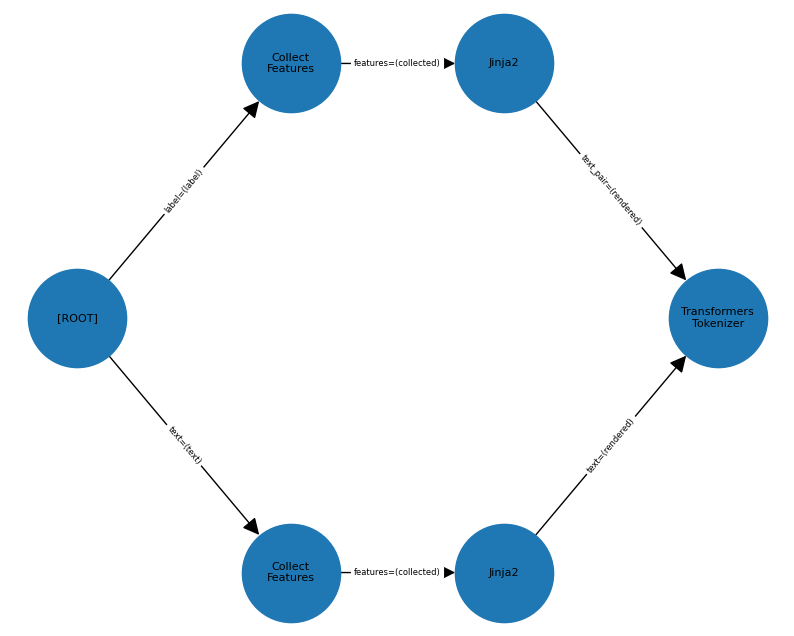

In [6]:
# visualize the data flow
_, ax = plt.subplots(1, 1, figsize=(10, 8))
flow.plot(ax=ax, node_font_size=8);

**Apply the Data Flow**

Execute the data flow on the loaded dataset and collect the results:

In [7]:
out_ds = flow.apply(ds, collect=encoding)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1305 > 1024). Running this sequence through the model will result in indexing errors


The generated output dataset now contains the `input_ids` produced by the tokenizer.

In [8]:
out_ds

Dataset({
    features: ['input_ids'],
    num_rows: 25000
})

## 5. Advanced Usage

### 5.1. Retrieving and Executing a Subflow

In some cases, you might want to execute only a part of the entire data flow. `hyped` allows you to build and execute subflows easily. Here's how to retrieve and execute a subflow.

**Extract a Subflow**

First, you can build a subflow from the existing data flow by specifying the output you want to collect. This subflow will include only the nodes required to compute the specified output.

This is also what happens under the hood when calling `apply`. It ensures that no compute is wasted on computations that do not contribute to the output.

In [9]:
sub_flow = flow.build(collect=input_tmpl)

**Visualize the Subflow**

You can visualize the subflow to understand its structure and the sequence of operations it includes:

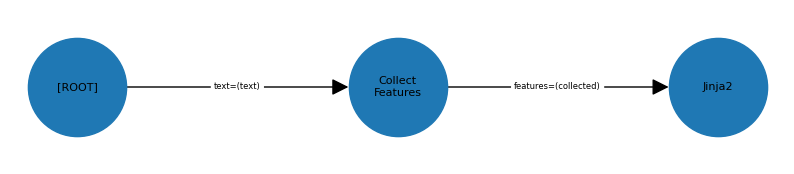

In [10]:
# visualize the sub-flow
_, ax = plt.subplots(1, 1, figsize=(10, 2))
sub_flow.plot(ax=ax, node_font_size=8);

**Execute the Subflow**

Finally, you can execute the subflow on the dataset. When a data flow is built as a subflow, you don't need to specify the `collect` parameter again:

In [11]:
raw_input_ds = sub_flow.apply(ds)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

The generated output dataset now only contains the rendered input text feature.

In [12]:
raw_input_ds

Dataset({
    features: ['rendered'],
    num_rows: 25000
})

In [13]:
raw_input_ds[0]

{'rendered': 'Input: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s 

### 5.2. Implementing a Custom Data Processor

`hyped` allows you to create custom data processors tailored to your specific data processing needs. This section demonstrates how to implement a custom processor.

In [14]:
from hyped.data.flow.refs.ref import FeatureRef
from hyped.data.flow.refs.inputs import CheckFeatureEquals, InputRefs
from hyped.data.flow.refs.outputs import OutputFeature, OutputRefs
from hyped.data.flow.processors.base import (
    Sample,
    BaseDataProcessor,
    BaseDataProcessorConfig
)
from typing_extensions import Annotated

**Define Custom Input and Output References**

First, define the custom input and output references. In `hyped` the input and output references are pydantic models with special validators to check/specify the feature type.
    
- `CustomInputRefs` defines the expected input features for the processor, where `x` must be a string feature.
- `CustomOutputRefs` defines the output features produced by the processor, where `y` will also be a string feature.

In [15]:
class CustomInputRefs(InputRefs):
    x: Annotated[FeatureRef, CheckFeatureEquals(datasets.Value("string"))]

class CustomOutputRefs(OutputRefs):
    y: Annotated[FeatureRef, OutputFeature(datasets.Value("string"))]

**Define the Custom Processor Configuration**

Next, define the configuration for the custom processor also in the form of a pydantic model.

- `CustomConfig` includes configurable parameters for the processor. Here, `val` is a configurable float parameter with a default value of `1.0`.

In [16]:
class CustomConfig(BaseDataProcessorConfig):
    val: float = 1.0

**Implement the Custom Processor**

Now, implement the custom processor by extending the BaseDataProcessor class.

- The `CustomProcessor` class implements the process method.
- `inputs` is a `Sample` containing the input features.
- `index` and rank provide additional information about the data sample being processed.
- The `process` method combines the `index` with the input feature `x` to produce the output feature `y`.

In [17]:
class CustomProcessor(BaseDataProcessor[CustomConfig, CustomInputRefs, CustomOutputRefs]):
    def process(self, inputs: Sample, index: int, rank: int) -> Sample:
        # access configuration values
        val = self.config.val
        # custom process function combining index and input feature
        # inputs has keys similar to the attributes of the input refs
        # outputs need to specify the keys of the output refs
        return Sample(y=f"Index {index} has content {inputs["x"]}")

**Use the Custom Processor in a Data Flow**

Instantiate the custom processor and add it to the data flow:

- `CustomProcessor(val=2.0)` creates an instance of the custom processor with val set to `2.0`.
- `call(x=flow.src_features.text)` specifies that the input feature `x` is the text feature from the dataset.

In [18]:
custom = CustomProcessor(val=2.0).call(x=flow.src_features.text)

**Visualize the Data Flow**

Visualize the data flow, including the custom processor:

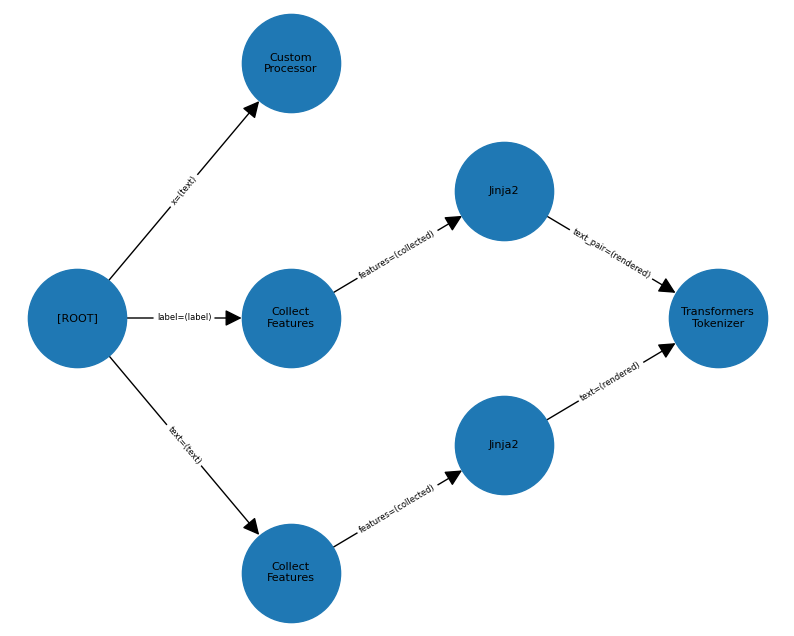

In [19]:
# visualize the data flow
_, ax = plt.subplots(1, 1, figsize=(10, 8))
flow.plot(ax=ax, node_font_size=8);

**Apply the Data Flow with the Custom Processor**

Execute the data flow, including the custom processor, on the dataset:

In [21]:
custom_ds = flow.apply(ds, collect=custom)

/Users/ndoll/dev/open-hyped/env/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.CustomConfig'>.
  StockPickler.save(self, obj, save_persistent_id)
/Users/ndoll/dev/open-hyped/env/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.CustomConfig'>: __main__.CustomConfig has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

The custom output dataset now contains the output feature `y` generated by the `CustomProcessor` instance.

In [22]:
custom_ds

Dataset({
    features: ['y'],
    num_rows: 25000
})

This example demonstrates how to create a custom processor in `hyped`, integrate it into a data flow, visualize the flow, and apply it to a dataset. Custom processors provide flexibility for implementing specialized data transformations.